In [5]:
# CÉLULA 1: INSTALAÇÃO (Execute esta e reinicie se for solicitado)
print("Iniciando instalação da biblioteca de controle...")
!pip install control
!pip install numpy scipy matplotlib

try:
    import control.matlab as ctrl
    print("Sucesso: A biblioteca 'control' foi importada!")
except ImportError:
    print("A biblioteca 'control' não pôde ser importada imediatamente.")
    print("Tentando instalar 'python-control' (nome alternativo)...")
    !pip install python-control
    # A exceção forçará uma mensagem de reinicialização CLARA para o usuário.
    raise Exception("Por favor, REINICIE a sessão do Colab (Runtime -> Restart runtime) para carregar a biblioteca instalada. Depois, execute a Célula 2.")

Iniciando instalação da biblioteca de controle...
Sucesso: A biblioteca 'control' foi importada!


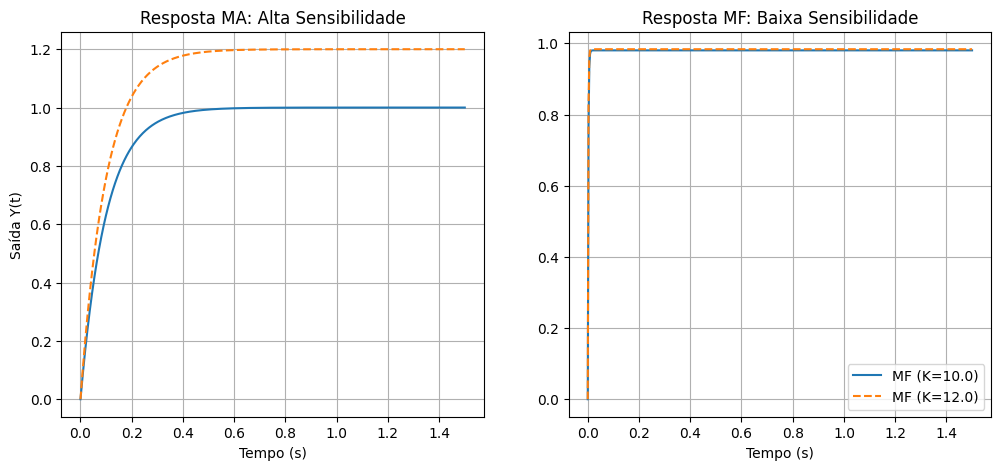

**Conclusão Sensibilidade:** A variação de 20% em K causa uma variação de 120.0% no valor final em Malha Aberta, mas é drasticamente atenuada em Malha Fechada, demonstrando o efeito do alto ganho $L(s) = 500.0/(s+10.0)$ na redução da Sensibilidade ($S_{G}^{T} = 1/(1+L(s))$).

1 states have been removed from the model
1 states have been removed from the model


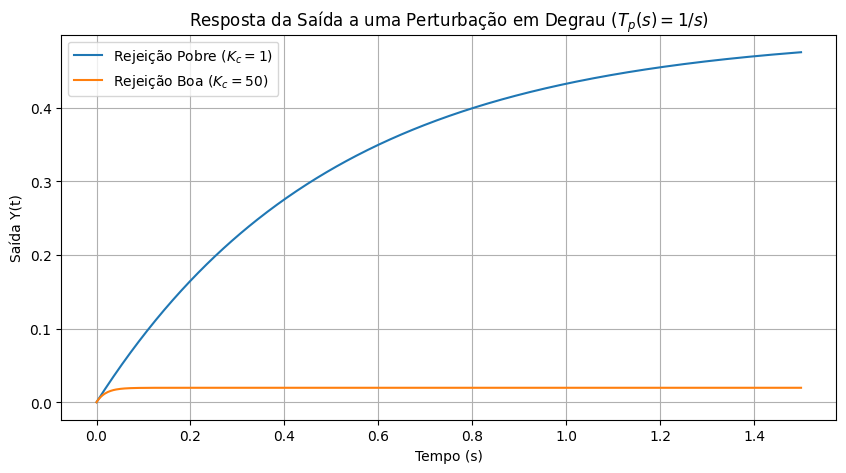

**Conclusão Rejeição:** Um ganho de controlador alto ($K_c=50$) resulta em um $e_{ss}$ de perturbação de $\approx 0.020$, muito menor que o $e_{ss}$ com ganho baixo ($\approx 0.475$). Isso confirma que $L(s)$ grande em baixa frequência (CC) é essencial para a rejeição de perturbações.

In [7]:
# CÉLULA 2: DEFINIÇÃO DE VARIÁVEIS E EXECUÇÃO (Execute SOMENTE após a Célula 1)

import control.matlab as ctrl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown as md

# --- Conteúdo Principal Módulos 4.1 e 4.2 ---

# --- Definição das Variáveis de Parâmetros ---
md("### Módulo 4.1: Análise de Sensibilidade a Variações de Parâmetros (G(s))")

K_nominal = 10.0
a = 10.0
Kc = 50.0  # Ganho do Controlador (alto, para reduzir sensibilidade)

# Processo (G(s) = K / (s+a))
num_G = [K_nominal]
den_G = [1, a]
G_nominal = ctrl.tf(num_G, den_G)

# Controlador (Gc(s) = Kc)
Gc = ctrl.tf([Kc], [1])

# Ganho de Malha Aberta (L(s) = Gc(s)G(s))
L_nominal = Gc * G_nominal

# Sistema em Malha Fechada (T(s))
T_nominal = ctrl.feedback(L_nominal, 1)

# --- Variação no Parâmetro (Simulando Incerteza) ---
delta_K = 2.0 # Variação de 20% (K = 12.0)
K_variado = K_nominal + delta_K

# 1. Malha Aberta (Variação afeta diretamente)
G_variado_MA = ctrl.tf([K_variado], [1, a])
T_MA_nominal = ctrl.tf([K_nominal], [1, a])

# 2. Malha Fechada (Variação atenuada)
L_variado_MF = ctrl.tf([Kc * K_variado], [1, a])
T_variado_MF = ctrl.feedback(L_variado_MF, 1)

# --- Simulação de Resposta ao Degrau (Sensibilidade) ---
T_sim = np.linspace(0, 1.5, 500)
y_MA_nominal, T_out = ctrl.step(T_MA_nominal, T_sim)
y_MA_variado, _ = ctrl.step(G_variado_MA, T_sim)
y_MF_nominal, _ = ctrl.step(T_nominal, T_sim)
y_MF_variado, _ = ctrl.step(T_variado_MF, T_sim)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(T_out, y_MA_nominal, label=f'MA (K={K_nominal})')
plt.plot(T_out, y_MA_variado, '--', label=f'MA (K={K_variado})')
plt.title('Resposta MA: Alta Sensibilidade')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída Y(t)')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(T_out, y_MF_nominal, label=f'MF (K={K_nominal})')
plt.plot(T_out, y_MF_variado, '--', label=f'MF (K={K_variado})')
plt.title('Resposta MF: Baixa Sensibilidade')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid()
plt.show()

# A linha problemática está aqui. Usando raw string (r) para evitar o SyntaxError.
md_sensibilidade = md(r"""**Conclusão Sensibilidade:** A variação de 20% em K causa uma variação de """ +
    f"{y_MA_variado[-1]/y_MA_nominal[-1] * 100:.1f}" + r"""% no valor final em Malha Aberta, mas é drasticamente atenuada em Malha Fechada, demonstrando o efeito do alto ganho $L(s) = """ +
    f"{Kc*K_nominal}/(s+{a})" + r"""$ na redução da Sensibilidade ($S_{G}^{T} = 1/(1+L(s))$)."""
)
display(md_sensibilidade)


# --- Módulo 4.2: Rejeição de Perturbações (L(s) Grande) ---

md("### Módulo 4.2: Rejeição de Perturbações ($T_p(s)$)")

# Processo G(s) = 1 / (s + 1) (Simplificação)
G_proc = ctrl.tf([1], [1, 1])

# Controlador Simples (Gc = K_rejeicao)
K_baixo = 1  # Ganho baixo para POBRE rejeição
K_alto = 50  # Ganho alto para BOA rejeição

# FT para a Perturbação (Y(s) / Tp(s)) = G(s) / (1 + L(s))
# K_baixo
L_baixo = ctrl.tf([K_baixo], [1, 1])
FT_pert_baixo = ctrl.minreal(G_proc / (1 + L_baixo))

# K_alto
L_alto = ctrl.tf([K_alto], [1, 1])
FT_pert_alto = ctrl.minreal(G_proc / (1 + L_alto))

# --- Simulação da Perturbação (Degrau Unitário) ---
y_pert_baixo, T_pert = ctrl.step(FT_pert_baixo, T_sim)
y_pert_alto, _ = ctrl.step(FT_pert_alto, T_sim)

plt.figure(figsize=(10, 5))
plt.plot(T_pert, y_pert_baixo, label=f'Rejeição Pobre ($K_c={K_baixo}$)')
plt.plot(T_pert, y_pert_alto, label=f'Rejeição Boa ($K_c={K_alto}$)')
plt.title('Resposta da Saída a uma Perturbação em Degrau ($T_p(s)=1/s$)')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída Y(t)')
plt.legend()
plt.grid()
plt.show()

# Calcula Erro em Regime Estacionário (valor final)
ess_pert_baixo = y_pert_baixo[-1]
ess_pert_alto = y_pert_alto[-1]

# CORREÇÃO NA LINHA 114: Escapando {ss} para que o Python não o confunda com uma variável
md(f"**Conclusão Rejeição:** Um ganho de controlador alto ($K_c={K_alto}$) resulta em um $e_{{ss}}$ de perturbação de $\\approx {ess_pert_alto:.3f}$, muito menor que o $e_{{ss}}$ com ganho baixo ($\\approx {ess_pert_baixo:.3f}$). Isso confirma que $L(s)$ grande em baixa frequência (CC) é essencial para a rejeição de perturbações.")